In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import  RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import silhouette_score, confusion_matrix
from RFBDoSBC.GetAndPrepareData import *
from RFBDoSBC.modelPreparation import *
from RFBDoSBC.modelEvaluation import *
from RFBDoSBC.plotData import *
from RFBDoSBC.utility import *


In [2]:

rad_mom_gen = res_pT_iterator()

In [94]:
rad, ptm = next(rad_mom_gen)
msg("Analyzing jets with R=%1.1f and p_T hardmin=%d"%(rad, ptm))


JEB: Analyzing jets with R=0.4 and p_T hardmin=20


In [95]:
best_params = loadBestParameters(rad, ptm)
best_params_lowpt = loadBestParameters(rad, ptm, True)
rfModel = [makeRandomForest(best_params) for _ in range(10)]
rfModelLowpt = [makeRandomForest(best_params_lowpt) for _ in range(10)]

batch_num = 0
feat_imp = {}

In [96]:
print(best_params_lowpt)

{'n_estimators': 200, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 100, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.1, 'max_features': 'auto', 'max_leaf_nodes': 1000, 'min_impurity_decrease': 0.0, 'class_weight': {1: 1, 2: 1, 3: 4}, 'max_samples': 0.9, 'oob_score': True, 'random_state': 42, 'n_jobs': -1}


In [97]:
dataGen = DataPipelineBatch(f"Analysis_Code/Generator Output/merged-ML-output-LOWSTATS-Rparam-{rad}-pThardmin-{ptm}.0.csv", ptm, True, False)




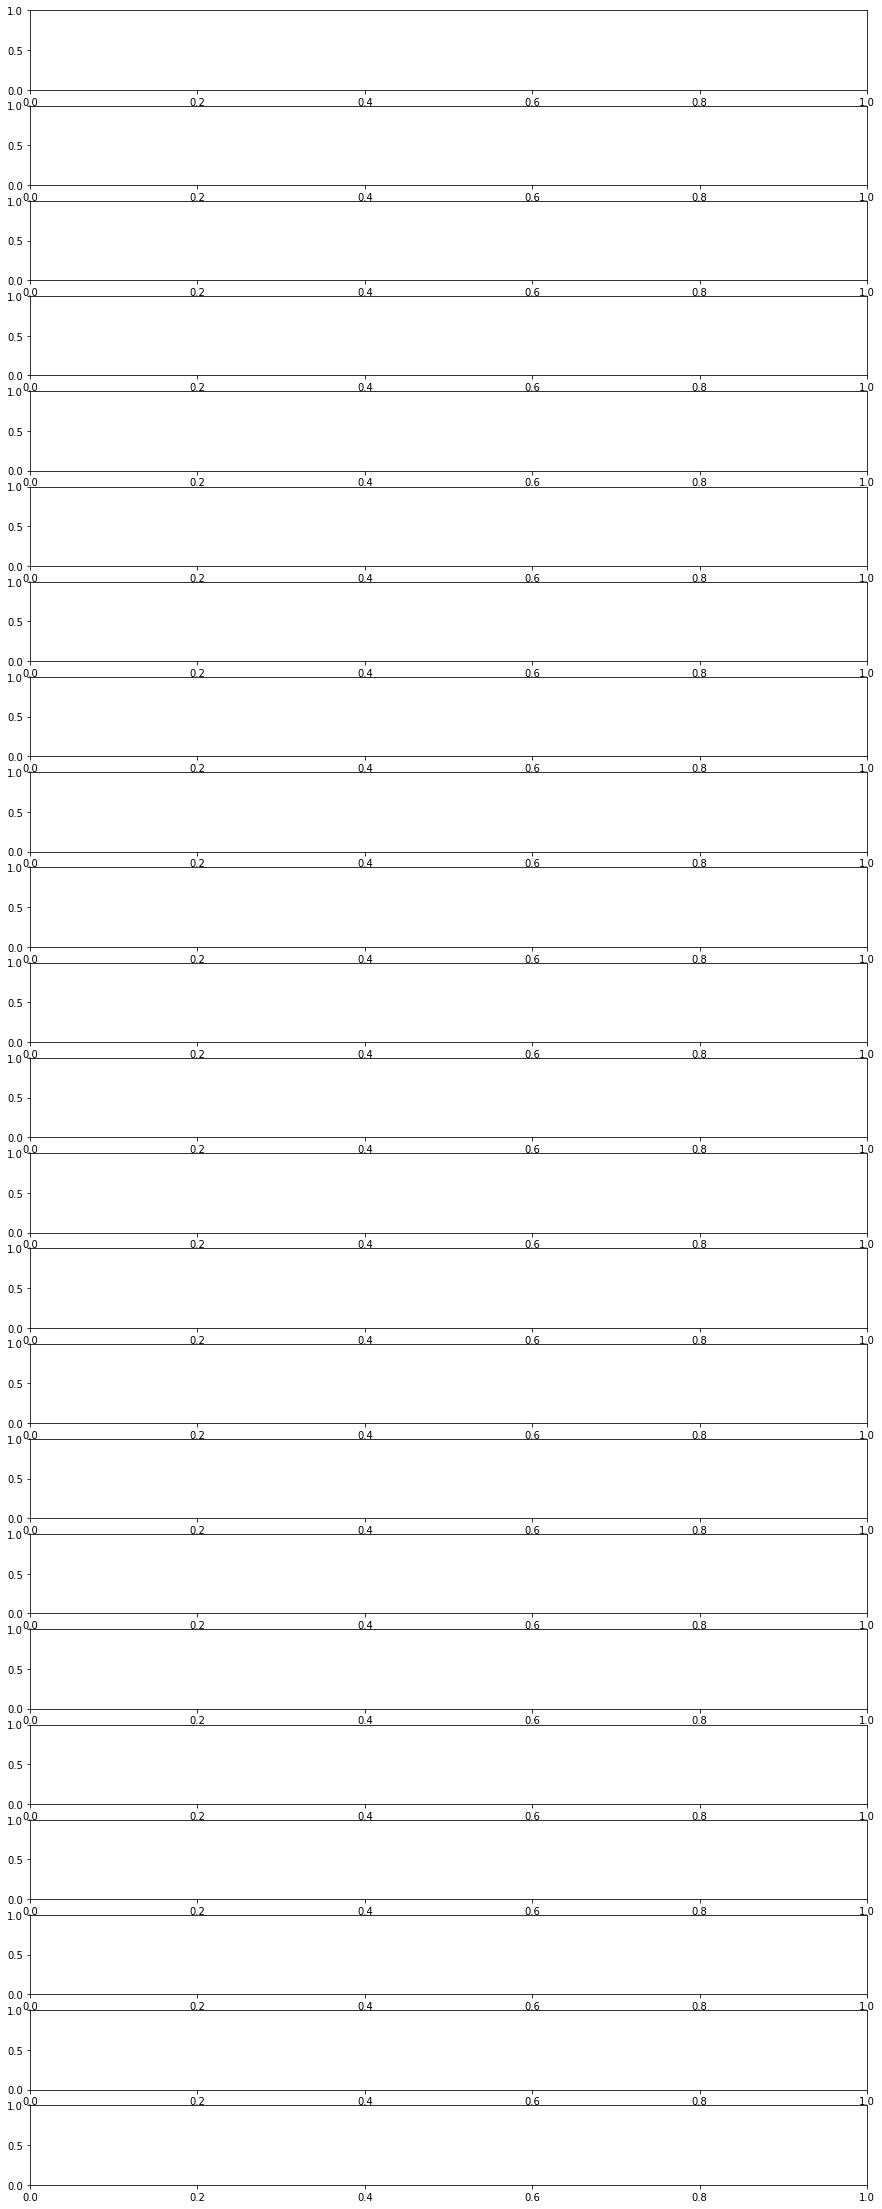

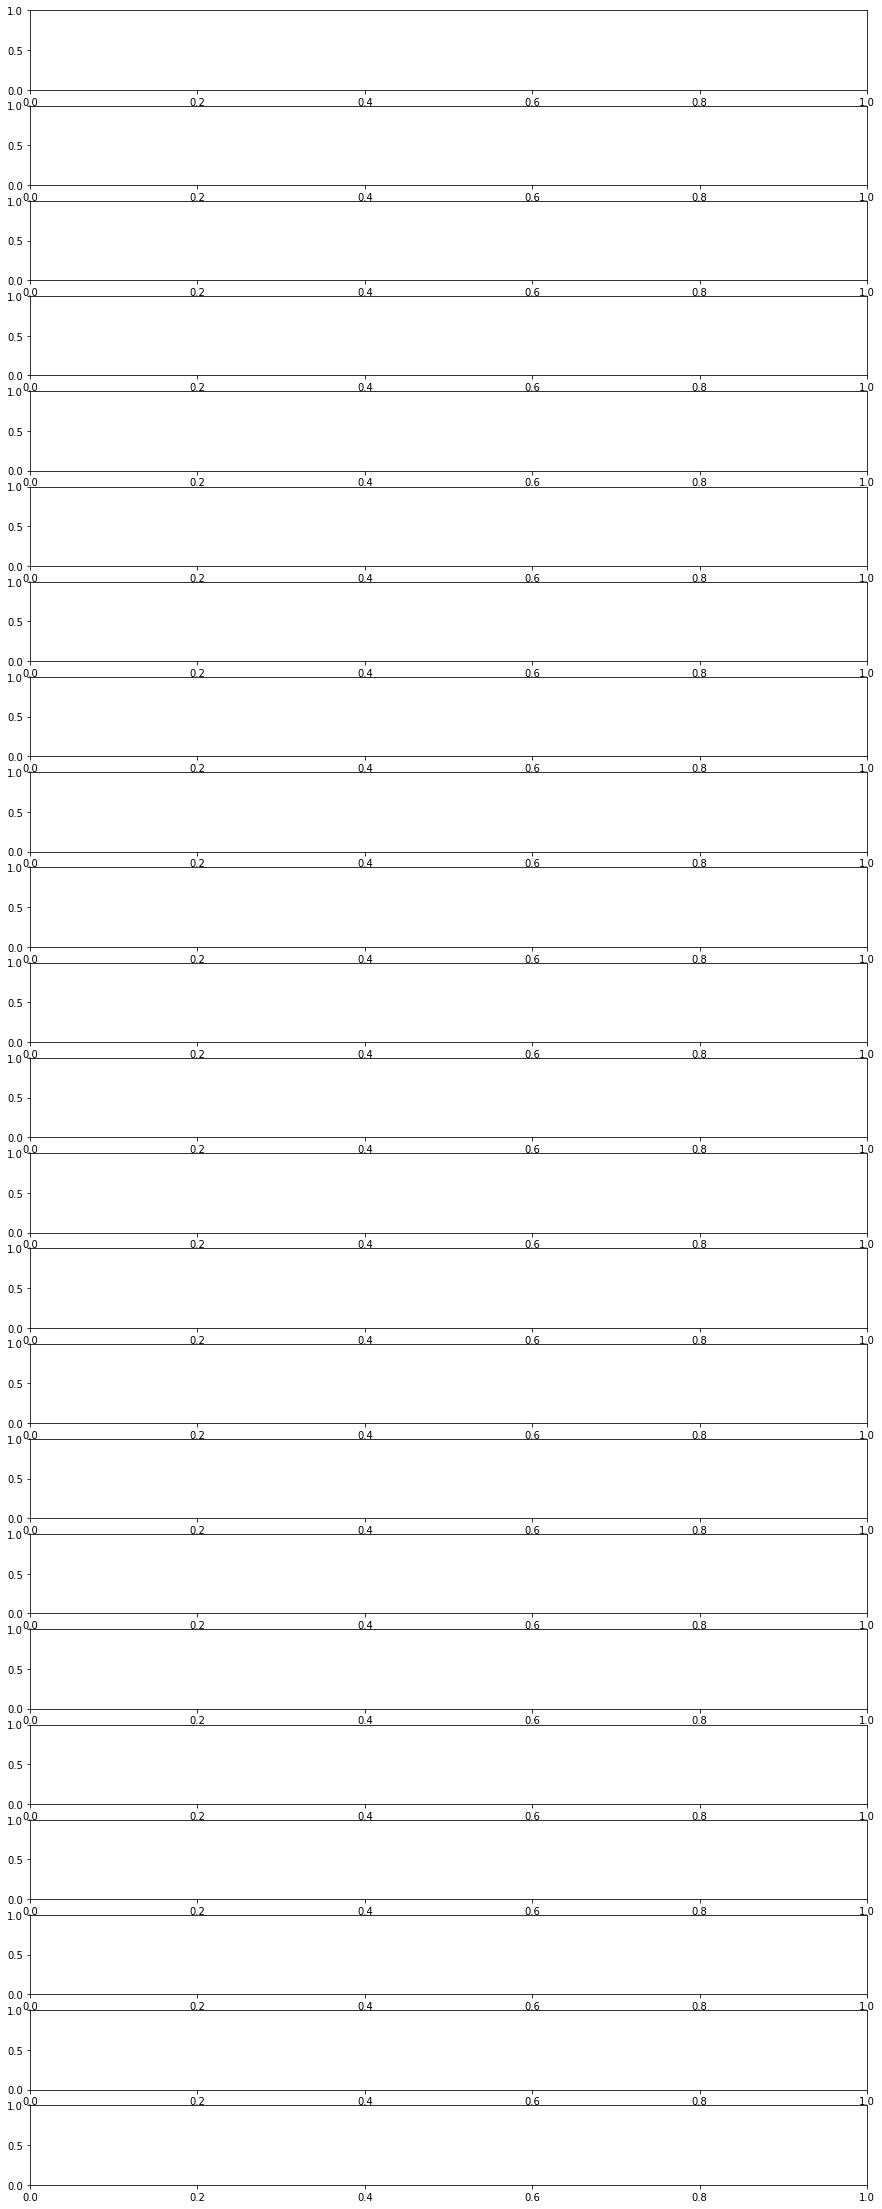

In [98]:
fig, ax = plt.subplots(8+15, 1, figsize=(15,40));
fig1, ax1 = plt.subplots(8+15, 1, figsize=(15,40));


In [99]:
do_plotting = False
low_pt = True

start_time = time.time()

while batch_num<12:
    try:
        print(f"Doing batch_num {batch_num}")
        
        train, test = next(dataGen)
        if low_pt:
            trainLowpt = train.loc[train['p_T']<100]

        #if(batch_num==1):
        #    sns.pairplot(data=train, hue='Label_Name')

        i=0

        X, Y = split_feat_label(train)
        if low_pt:
            XLowpt, YLowpt = split_feat_label(trainLowpt)

        rfModel[batch_num] = doRandomForestFit(X, Y, rfModel[batch_num], batch_num)
        if low_pt:
            rfModelLowpt[batch_num] = doRandomForestFit(XLowpt, YLowpt, rfModelLowpt[batch_num], batch_num)

        if do_plotting:
            print("Plotting...")
            if not low_pt:
                for feat in train.columns:

                    if feat in ['p_T', 'Label_Name']:
                        continue
                    sns.scatterplot(data=train, x='p_T',y=feat, hue='Label_Name',hue_order=["Fake", "< Hard Scattering p_T", ">= Hard Scattering p_T"], alpha=0.005, ax=ax[i], s=1)
                    ax[i].legend([],[])
                    i+=1

            else:
                for feat in train.columns:
                    if feat in ['p_T', 'Label_Name']:
                        continue
                    sns.scatterplot(data=trainLowpt, x='p_T',y=feat, hue='Label_Name',hue_order=["Fake", "< Hard Scattering p_T", ">= Hard Scattering p_T"], alpha=0.005, ax=ax1[i], s=1)
                    ax1[i].legend([],[])
                    i+=1

        batch_num+=1
    except StopIteration:
        print(f"No more data in batch num: {batch_num}, trimming forest.")
        rfModel = rfModel[:batch_num]
        if low_pt:
            rfModelLowpt = rfModelLowpt[:batch_num]
        break
train_and_plot_time = time.time()-start_time
if do_plotting:
    print("Saving...")
    if not low_pt:
        fig.legend(["Fake", "< Hard Scattering p_T", ">= Hard Scattering p_T"])
        fig.savefig(f'all_jet_features_R{rad}_pt{ptm}.png', format='png', dpi=600)
    else:
        fig1.legend(["Fake", "< Hard Scattering p_T", ">= Hard Scattering p_T"])
        fig1.savefig(f"lowp_T_jet_features_R{rad}_pt{ptm}.png", format='png', dpi=600)

save_time = time.time()-train_and_plot_time

print(f"It took {train_and_plot_time/1000}s to train and plot. It took {save_time/1000}s to save")

Doing batch_num 0
JEB: Fitting to data for batch 0.
JEB: Fitting to data for batch 0.
Doing batch_num 1
JEB: Fitting to data for batch 1.
JEB: Fitting to data for batch 1.
Doing batch_num 2
No more data in batch num: 2, trimming forest.
It took 0.09589522194862365s to train and plot. It took 1623863.585296648s to save


In [100]:
train, test = DataPipeline(f"Analysis_Code/Generator Output/merged-ML-output-LOWSTATS-Rparam-{rad}-pThardmin-{ptm}.0.csv", ptm, 200000000, True)
trainLowpt = train.loc[train['p_T']<100]

X, Y = split_feat_label(train)

XLowpt, YLowpt = split_feat_label(trainLowpt)


In [101]:
oracle = doOracleFit(X, rfModel, rad, ptm)
oracleLowpt = doOracleFit(XLowpt, rfModelLowpt, rad, ptm, True)

JEB: Initializing Oracle and fitting to rfModel's predictions
(2, 1230592) [[3 3 1 ... 1 2 1]
 [3 3 1 ... 1 2 1]]
(1230592,) 0          3
1          3
2          1
3          3
4          2
          ..
1230587    2
1230588    3
1230589    1
1230590    2
1230591    1
Length: 1230592, dtype: int64
[1 2 3]
JEB: Initializing Oracle and fitting to rfModel's predictions
(2, 647121) [[1 2 2 ... 2 1 1]
 [1 2 2 ... 2 1 1]]
(647121,) 0         1
1         2
2         2
3         2
4         2
         ..
647116    1
647117    1
647118    2
647119    1
647120    1
Length: 647121, dtype: int64
[1 2]


In [102]:
from sklearn.metrics import accuracy_score

Xtest, Ytest = split_feat_label(test)

testLowpt = test.loc[test['p_T']<100]

XtestLowpt, YtestLowpt = split_feat_label(testLowpt)

oracle_test_predictions = oracle.predict(Xtest)

oracleLowpt_test_predictions = oracleLowpt.predict(XtestLowpt)

print(f"Oracle accuracy: {accuracy_score(Ytest, oracle_test_predictions)}")
print(f"Oracle Low p_T accuracy: {accuracy_score(YtestLowpt, oracleLowpt_test_predictions)}")

for i,rf in enumerate(rfModel):
    rf_predictions = rf.predict(Xtest)
    print(f"Random Forest accuracy, model {i}: {accuracy_score(Ytest, rf_predictions)}")

for i,rf in enumerate(rfModelLowpt):
    rf_predictions = rf.predict(XtestLowpt)
    print(f"Random Forest accuracy, model {i}: {accuracy_score(YtestLowpt, rf_predictions)}")

Oracle accuracy: 0.6609675311800136
Oracle Low p_T accuracy: 0.614099772344848
Random Forest accuracy, model 0: 0.6940864426668053
Random Forest accuracy, model 1: 0.6964397738981761
Random Forest accuracy, model 0: 0.6150153419776304
Random Forest accuracy, model 1: 0.6158566762347818


JEB: Computing feature importances and other model statistics.
JEB: Feature rankings:
1. Area (0.390901)
2. p_T-corr (0.280690)
3. Epsilon (0.156902)
4. Mean-p_T (0.115264)
5. Angularity (0.056242)
JEB: Plotting feature importances.
JEB: Plot distribution of importances.
JEB: Computing performance metrics
Number of Real Jets train: 409862
Number of Fake Jets train: 409983
Real Jet Rate train: 0.9490487041979984
Fake Jet Rate train: 0.528382884168368
Squish Jet Rate train: 0.6037999060248767
Fake predicted real train: 0.056624299056302334
Real predicted fake train: 0.0007002356890855947
Number of Real Jets test: 102885
Number of Fake Jets test: 102764
Real Jet Rate test: 0.9480487923409632
Fake Jet Rate test: 0.5294558405667354
Squish Jet Rate test: 0.6037843137254902
Fake predicted real test: 0.05793857771203924
Real predicted fake test: 0.0006998104679982504
JEB: Computing feature importances and other model statistics.
JEB: Feature rankings:
1. Area (0.385925)
2. p_T-corr (0.284113)


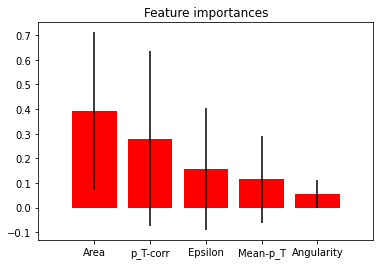

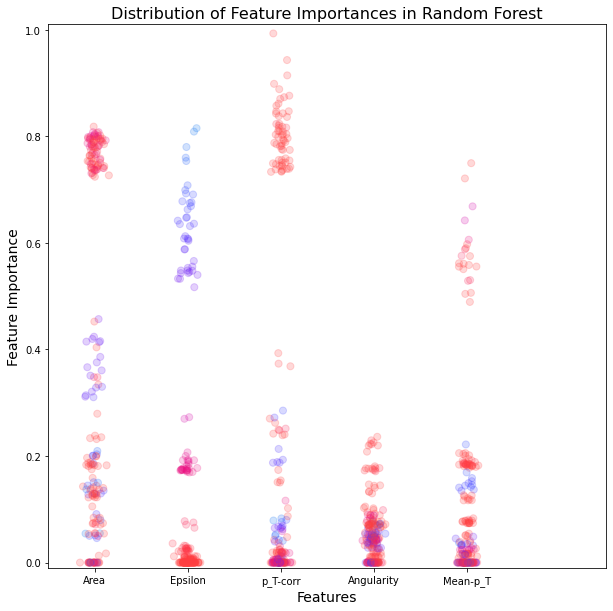

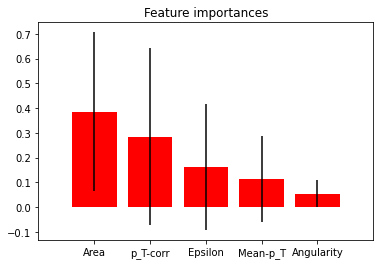

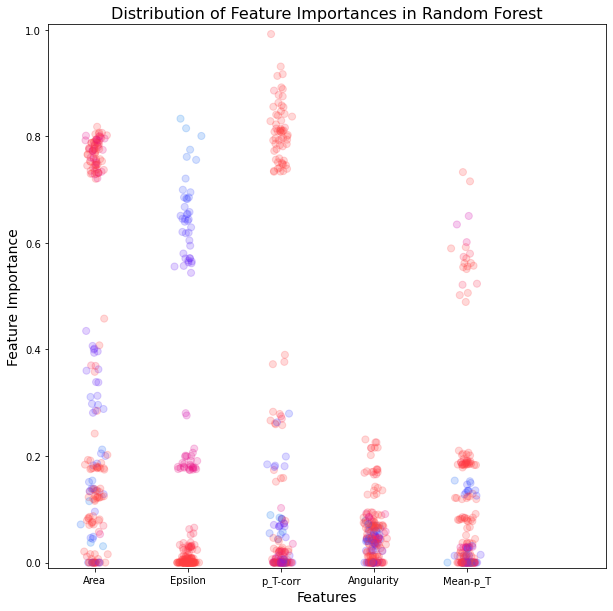

In [103]:
feat_imps = []
model_no=0
for model in rfModel:
    feat_imp = {}
    doModelEvaluation(X, Y, Xtest, Ytest, model, rad, ptm, feat_imp,False, model_no)
    feat_imps.append(feat_imp)
    model_no+=1
print(feat_imps)

JEB: Computing feature importances and other model statistics.
JEB: Feature rankings:
1. Area (0.588308)
2. Angularity (0.317684)
3. p_T-corr (0.047929)
4. Mean-p_T (0.024756)
5. Epsilon (0.021323)
JEB: Plotting feature importances.
JEB: Plot distribution of importances.
JEB: Computing performance metrics
Number of Real Jets train: 3634
Number of Fake Jets train: 354707
Real Jet Rate train: 0.0
Fake Jet Rate train: 0.6489835272492508
Squish Jet Rate train: 0.5795796107763695
Fake predicted real train: 0.0
Real predicted fake train: 0.10924600990643918
Number of Real Jets test: 876
Number of Fake Jets test: 88986
Real Jet Rate test: 0.0
Fake Jet Rate test: 0.6500797878317938
Squish Jet Rate test: 0.5790544117237344
Fake predicted real test: 0.0
Real predicted fake test: 0.11757990867579908
JEB: Computing feature importances and other model statistics.
JEB: Feature rankings:
1. Area (0.591695)
2. Angularity (0.303067)
3. p_T-corr (0.053367)
4. Mean-p_T (0.026754)
5. Epsilon (0.025118)
JE

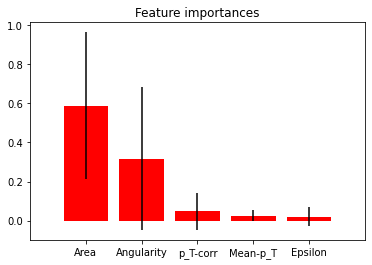

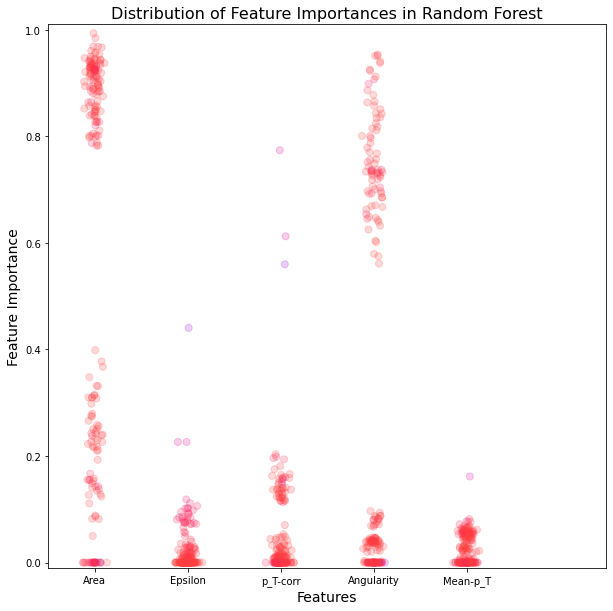

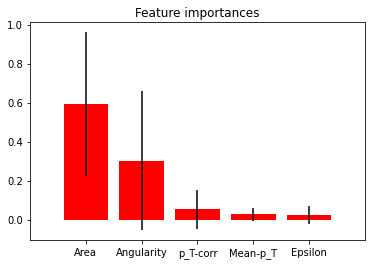

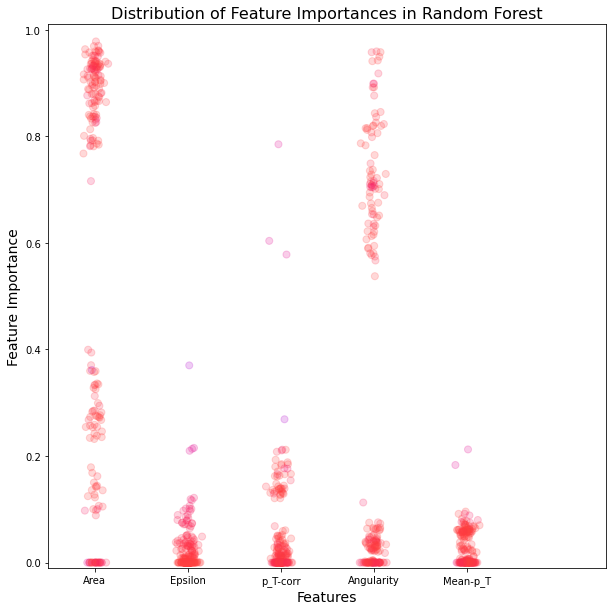

In [104]:
feat_imps_lowpt = []
model_no=0
for model in rfModelLowpt:
    feat_imp = {}
    doModelEvaluation(XLowpt, YLowpt, XtestLowpt, YtestLowpt, model, rad, ptm, feat_imp, True, model_no)
    feat_imps_lowpt.append(feat_imp)
    model_no+=1
print(feat_imps_lowpt)